## Welcome to E-tivity 1: Artificial Neural Networks from Start to Finish

Your Name: Zheng Hanming

Your Student ID Number: 21225621

### Objective:
*Address a Binary Classification problem using:*
1. a Logistic Regression Model, and
2. a Shallow Artificial Neural Network

### Important Notice
*Given the subjectivity that goes in to the parameters and hyper-parameters underlying a Neural Network (no matter how simple),
and the range of choices that may produce a 'good' result, you will be required to provide reasoning for your choices in
your post e-tivity reflection. Specifically, you are required to reflect on your implementation of Tasks 5, 6, and 7, and
on the model that provides a superior performance in validation tests. This includes:*

1. *providing your rationale for the hidden layer specifications when forming the Neural Network architecture, and*
2. *the choice of hyperparameters used to train both models*
3. *noting which model performed better, and providing a couple potential reasons for the result*

*In addition, if you choose to deviate from the 'default' options provided throughout the notebook, you will be required to provide rationale for:*

- *Choosing which extra features to drop from the dataframe (Task 2)*
- *Changing the probability threshold to classify it as 'paid' or 'defaulted' (Task 8)*

*To facilitate this, you may be better served to leave comments for each task that is subject to interpretation (e.g.
choice of neurons and layers in a neural network, etc.) following every task, so that your rationale and thought process
can be threaded through the script.*

**The best-performing network (performed on an additional holdout set following e-tivity submission) gets 2 extra marks in
addition to the rubric-graded scores, so long as it remains within the specifications identified in the notebook.**

### More Information
Using 30,000 samples taken from a Taiwanese Credit Card Company from April-September 2005, we attempt to predict the clients
that will default on their loans in the next month. We will classify our predictions as either 0 ('Paid') or 1 ('Defaulted').

We will be using a variety of characteristics about the account to aid in our prediction decisions, specifically the
account holder's:
- personal characteristics
- granted credit line
- historical bill statements
- repayment history, and
- repayment status

Given the high proportion of people that pay their bills rather than letting their accounts go into default, we are expecting
class imbalance issues to present - where the number of those who pay their bills will outweigh the number of those who
default on their debts. This poses a key challenges in that we have to be clever about how we assess the 'accuracy' of
our models: a naive 'Paid' prediction may appear on the surface to return a very positive result, but in practice this
prediction would be a functionally useless result.

We will be assessing the performance of two predictive models on this task, each increasing the level of complexity they
bring to the analysis. These are:
- a **Logistic Regression** model, which operates in a linear space
- an **Artificial Neural Network** classifier, which operates in an arbitrarily non-linear, high dimensional space.

This notebook is split into two parts. First, we will see how these models can be deployed rapidly using the Scikit-learn
package, which is a very popular framework for implementing Machine Learning models. After that, we will turn our attention
to another coding framework that specialises in Deep Learning implementations: PyTorch.

### PyTorch
PyTorch is very popular in the Deep Learning community as it grants you the ability to fully customise and adapt your neural network implementations. It
will also allow us to better demonstrate how Artificial Neural Networks, and by extension all other neural network types,
are just an extension of Linear and Logistic Regression models. For the remainder of the module, we will be implementing
neural networks using PyTorch instead of TensorFlow You can find out more about PyTorch here: https://pytorch.org/features/.

#### Install required packages and libraries:

In [402]:
# if there are import issues, you may have to install the packages first:

# !pip install jupyter
# !pip install -U setuptools
# !pip install pandas numpy matplotlib missingno re seaborn scikit-learn torch traceback

In [403]:
# Some packages installed specifically for this task

from datetime import date
today = date.today()
today = today.strftime("%d/%m/%Y")

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import missingno

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay)

import re, traceback

In [404]:
# Some further packages that will be used for ease of implementation (a pre-configured Logistic Regression Model and
# Artificial Neural Network to train, validate, and test on) before we go on to configure the models ourselves.

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [405]:
# Another few packages that import the Deep Learning framework will be using for the remainder of the FI6015 module. The
# 'PyTorch' Deep Learning framework system allows for full neural network flexibility and customisation.

import torch
from torch.utils.data import (TensorDataset, DataLoader)
from torch import (nn, optim)

In [406]:
%matplotlib inline
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# set seed for reproducibility - PLEASE DO NOT CHANGE
torch.manual_seed(1)

1.12.1+cpu


#### Data Import and Initial Inspection

In [407]:
data = pd.read_csv('./Credit_Card_Clients.csv')
data

ID  LIMIT_BAL  GENDER  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  \
0          1      20000       2          2         1   24      2      2   
1          2     120000       2          2         2   26     -1      2   
2          3      90000       2          2         2   34      0      0   
3          4      50000       2          2         1   37      0      0   
4          5      50000       1          2         1   57     -1      0   
...      ...        ...     ...        ...       ...  ...    ...    ...   
29995  29996     220000       1          3         1   39      0      0   
29996  29997     150000       1          3         2   43     -1     -1   
29997  29998      30000       1          2         2   37      4      3   
29998  29999      80000       1          3         1   41      1     -1   
29999  30000      50000       1          2         1   46      0      0   

       PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
0         -1     -1     -2     -2       3913       3102        689          0   
1          0      0      0      2       2682       1725       2682       3272   
2          0      0      0      0      29239      14027      13559      14331   
3          0      0      0      0      46990      48233      49291      28314   
4         -1      0      0      0       8617       5670      35835      20940   
...      ...    ...    ...    ...        ...        ...        ...        ...   
29995      0      0      0      0     188948     192815     208365      88004   
29996     -1     -1      0      0       1683       1828       3502       8979   
29997      2     -1      0      0       3565       3356       2758      20878   
29998      0      0      0     -1      -1645      78379      76304      52774   
29999      0      0      0      0      47929      48905      49764      36535   

       BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0              0          0         0       689         0         0         0   
1           3455       3261         0      1000      1000      1000         0   
2          14948      15549      1518      1500      1000      1000      1000   
3          28959      29547      2000      2019      1200      1100      1069   
4          19146      19131      2000     36681     10000      9000       689   
...          ...        ...       ...       ...       ...       ...       ...   
29995      31237      15980      8500     20000      5003      3047      5000   
29996       5190          0      1837      3526      8998       129         0   
29997      20582      19357         0         0     22000      4200      2000   
29998      11855      48944     85900      3409      1178      1926     52964   
29999      32428      15313      2078      1800      1430      1000      1000   

       PAY_AMT6  default_payment_next_month  
0             0                           1  
1          2000                           1  
2          5000                           0  
3          1000                           0  
4           679                           0  
...         ...                         ...  
29995      1000                           0  
29996         0                           0  
29997      3100                           1  
29998      1804                           1  
29999      1000                           1  

[30000 rows x 25 columns]

From looking at the dataset, we see we have one variable that will act as our target variable:
whether or not the client will have a **default payment next month**.

### Checklist for Data Pre-processing and Exploration

Before performing a statistical analysis on the imported dataframe, it is very import to inspect and explore the data
you will be analysing. Getting to know your data from the outset will allow you to troubleshoot issues much easier, will
allow you to interpret your model's output much faster, and will allow you to assess whether the data is suitable for the
statistical technique you seek to employ.

Below is a non-exhaustive checklist of data explorations you should perform when first importing numerical data:
- Data types, and memory usage
- Data Missingness, and reasons for missingness
- Distributional Properties of individual features / variables
- Correlation Heatmap
- One-hot Encoding (if required)
- Split target from predictors
- Randomising values (as long as observations are not stated sequentially) according to a random seed that **does not change**
- Train / Validation / Test split with no information leakage
- Centring and Standardisation
- (Optional) K-fold Cross-validation

### Preprocessing Step 1: Data types, and memory usage

In [408]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   GENDER                      30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

- every variable is a numeric type (int) and available to analyse within the models without causing errors.
- Loading the data uses 5.7mb of memory - very manageable.

#### Extra Data Information
- **ID**: ID of each client
- **LIMIT_BAL**: Amount of given credit in Taiwanese Dollars (includes individual and family/supplementary credit)
- **GENDER**: 1=male, 2=female
- **EDUCATION**: 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown
- **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
- **AGE**: Age in years
- **PAY_0**: Repayment status in September, 2005
    - -2: No consumption (inactive account: balance paid in full and no transactions this period)
    - -1: Paid in full (active account: balance paid in full, but account has a balance remaining due to recent transactions)
    - 0: The use of revolving credit (Customer paid the minimum due amount, but not the entire balance)
    - 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months
- **PAY_2**: Repayment status in August, 2005 (scale same as above)
- **PAY_3**: Repayment status in July, 2005 (scale same as above)
- **PAY_4**: Repayment status in June, 2005 (scale same as above)
- **PAY_5**: Repayment status in May, 2005 (scale same as above)
- **PAY_6**: Repayment status in April, 2005 (scale same as above)
- **BILL_AMT1**: Amount of bill statement in September, 2005 (Taiwanese Dollars)
- **BILL_AMT2**: Amount of bill statement in August, 2005 (Taiwanese Dollars)
- **BILL_AMT3**: Amount of bill statement in July, 2005 (Taiwanese Dollars)
- **BILL_AMT4**: Amount of bill statement in June, 2005 (Taiwanese Dollars)
- **BILL_AMT5**: Amount of bill statement in May, 2005 (Taiwanese Dollars)
- **BILL_AMT6**: Amount of bill statement in April, 2005 (Taiwanese Dollars)
- **PAY_AMT1**: Amount of previous payment in September, 2005 (Taiwanese Dollars)
- **PAY_AMT2**: Amount of previous payment in August, 2005 (Taiwanese Dollars)
- **PAY_AMT3**: Amount of previous payment in July, 2005 (Taiwanese Dollars)
- **PAY_AMT4**: Amount of previous payment in June, 2005 (Taiwanese Dollars)
- **PAY_AMT5**: Amount of previous payment in May, 2005 (Taiwanese Dollars)
- **PAY_AMT6**: Amount of previous payment in April, 2005 (Taiwanese Dollars)
- **default_payment_next_month**: Whether payment defaulted in next month (1=yes, 0=no)

### Preprocessing Step 2: Data Missingness, and reasons for missingness

In [409]:
missingno.matrix(data)
plt.show()

No missing values. Very rare to see this in practice. It is likely that this is a significantly reduced subset of a much
larger dataset, where only the observations with full data completeness are included.

### Preprocessing Step 3: Correlation Heatmap

In [410]:
correlations = data.corr()

plt.figure(figsize=(18, 15))
plt.title('Correlation Heatmap of Included Variables')
sns.heatmap(correlations, annot = True, vmin = -1, cmap = 'BrBG', linewidth = 0.1, linecolor = 'white')
# coolwarm cmap also a good choice

<AxesSubplot:title={'center':'Correlation Heatmap of Included Variables'}>

Apart from payment status for the months leading up to October ('next month'): 'Pay_0', 'Pay_2', and so on, there are no
standout correlations that will significantly influence the outcome on their own.

'Limit_bal', which indicates the size of the line of credit extended to the client, is another notable correlation. This
variable is negatively correlated with the likelihood of defaulting. In other words, more available to spend = lower
likelihood of default, presumably because higher lines of credit are extended to reliable clients who have long histories
of paying their balance on time.

The implication of the (generally) low correlation values is that if we do get accurate predictive models, it will be because
there are interaction effects amongst the variables that are difficult to see at first sight - they combine to tell a story
about the likelihood of an account defaulting. If this is the case, the data collectors should feel validated in their
attempts to collect more data (25 variables) than many would feel necessary (i.e. focusing on collecting a few
highly-correlated factors). Non-linearities may also present within the interactions across different variables,
warranting the inclusion of the Artificial Neural Network model.


### Preprocessing Step 4: Distributional Properties

In [411]:
data.describe().transpose().style.format("{:.2f}")

- Mean of 'default_payment_next_month' = 0.22 means that roughly 22% of the accounts defaulted in the next month. This is
much higher than one would expect, indicating a cherry-picked dataset. In any case, we will continue with our analysis.
Such a high proportion actually makes it easier for the model to produce accurate results.

- **Education** & **Marriage**: Nominal (multi-category) variables, which will pose issues in terms of how the model
interprets the data being passed into it. These variables will have to be re-categorised as binary variables. **Gender**
is also nominal but may be ok as there are only two categories (if a change is made, it would only to shift the values
from 1-2 to 0-1).
- **Pay Status**: Model throughput issues may present, but the data appears to be ordinal (order of numbers **does** matter)
so we may be ok. Clients are scored according to the payment made: penalised with +1 for every monthly payment in arrears,
-2 (penalty reduction) if full balance is cleared and account is inactive, -1 (penalty reduction) if full payment is made
but account is still active, and 0 if minimum payment is made to keep the account in good credit standing.
- **Bill Amounts**: No model throughput issues here. May expect to see more defaults the higher the bill amounts go.
Interesting to note that a few clients are owed a refund for overpaying (negative values).
- **Pay Amounts**: No model throughput issues here. May expect to see more defaults on the accounts with no / low bill amounts
paid across successive months.

### Preprocessing Step 5: One-hot Encoding

Based on the above throughput issues that will inevitably lead to misleading results, we will split the nominal variables into
binary yes / no (1 / 0) variables using one-hot encoding. To do this, we will leverage the 'get_dummies' function in pandas,
which essentially does the one-hot encoding process for us - it automatically identifies all categories in each nominal
variable, and splits them into dummy variables in a separate dataframe.

Once the one-hot encoding operation is complete, each of the nominal categories will be represented as its own feature.

## Task 1: Generate dummy / one-hot-encoded variables, and transform the original dataframe.

Categorical variables cannot be interpreted in their original form, as statistical models will assume a hierarchy in the
numbers - '2' will be seen as more prominent than '1', '3' will be seen as more prominent than '2' and '1', and so on.

To sidestep this issue, we will one-hot-encode our categorical variables, which includes creating new dummy binary variables,
and assigning each category to a different binary variable.

Each binary variable will return a '1' corresponding to the row in which that category was observed in the original variable,
and '0' otherwise. For more insights, see section 6.3.4 here: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features

1. You will extract each category from each original categorical column variable(s) using the `pd.get_dummies()`
 function, and store them in a dataframe named `dummies`.
2. You will then concatenate the original dataframe with the `dummies` dataframe.
3. You will then drop the original categorical column variables from the concatenated dataframe, removing the non-interpretable
 features from the analysis, and return the transformed dataframe.

*Hint: you may find the following documentation useful:*
- https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html.
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
- https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [412]:
"""
Passes in unscaled input data for the neural network, and outputs scaled data to be used as input for the neural network.

Parameters
---------
df : df
    dataframe from which to extract categorical (nominal) variables.
column_categories : dict
    dictionary mapping the column variables we seek to one-hot-encode to a user-defined prefix.

Returns
-------
df : df
    transformed dataframe where categorical variables are remapped to one-hot-encoded variables
"""

'\nPasses in unscaled input data for the neural network, and outputs scaled data to be used as input for the neural network.\n\nParameters\n---------\ndf : df\n    dataframe from which to extract categorical (nominal) variables.\ncolumn_categories : dict\n    dictionary mapping the column variables we seek to one-hot-encode to a user-defined prefix.\n\nReturns\n-------\ndf : df\n    transformed dataframe where categorical variables are remapped to one-hot-encoded variables\n'

In [413]:
def onehot_encoding(df, column_categories):

    df = df.copy()

    # we use the .items() function to access all unique categories within each nominal variable. The unique categories
    # are stated as '0', '1', etc. in order. We refine these automatically generated category names by adding a prefix.
    for column, prefix in column_categories.items():
        ##**YOUR CODE STARTS HERE**
        dummies = pd.get_dummies(df[column], prefix = prefix)
        # concatenate the one-hot encoded variables with the original dataframe
        df =  pd.concat([df, dummies], axis = 1)
        # drop the original nominal variable from the dataframe as it is no longer needed
        df = df.drop([column], axis = 1)
        ##**YOUR CODE ENDS HERE**
    return df

In [414]:
##**YOUR CODE STARTS HERE**
# We will be encoding two nominal variables ('EDUCATION' and 'MARRIAGE').
one_hot_encoded_data = onehot_encoding(data, {'EDUCATION': 'Edu', 'MARRIAGE': 'Mar'})
# print the result of encoding
one_hot_encoded_data.describe().transpose().style.format("{:.2f}")
##**YOUR CODE ENDS HERE**

### Preprocessing Step 6: Drop unnecessary features, split target from predictors

## Task 2: Drop unnecessary features and transform the one-hot encoded dataframe.

To prepare our dataframe for analysis, we must remove features that add no statistical value. Furthermore,
we must split our dataframe in two, separating the outcome values from the values we will be using to predict the outcome.
This involves completing three steps:

1. Drop unnecessary features from the predictive dataframe. We will be dropping the 'ID' column as it adds no value, statistically-speaking.
	- **note**: you are free to return to this function at a later point to drop more features from the dataframe to improve
	 the predictive capabilities of your models. However, you should provide rationale for your choices.
2. Generate a single-column 'y' dataframe containing all `default_payment_next_month` values
3. Drop all `default_payment_next_month` values from the 'X' dataframe.

*Hint:*
- *you may find the following documentation useful: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html*

In [415]:
"""
Passes in a one-hot-encoded dataframe, removes features that add no value to the analysis, splits the dataframe in to
predictor and response variable dataframes, and outputs two dataframes primed for analysis.

Parameters
---------
df : df
    one-hot-encoded dataframe to prepare for analysis.

Returns
-------
X : df
	Dataframe containing predictor variables
y : df
	Dataframe containing values to be predicted
"""

'\nPasses in a one-hot-encoded dataframe, removes features that add no value to the analysis, splits the dataframe in to\npredictor and response variable dataframes, and outputs two dataframes primed for analysis.\n\nParameters\n---------\ndf : df\n    one-hot-encoded dataframe to prepare for analysis.\n\nReturns\n-------\nX : df\n\tDataframe containing predictor variables\ny : df\n\tDataframe containing values to be predicted\n'

In [416]:
def preprocess_dataframe(df):
    df = df.copy()

    ##**YOUR CODE STARTS HERE**
    # Drop unnecessary features
    df = df.drop(['ID'], axis=1)
    # Split target from predictors
    # y is the label
    y = df['default_payment_next_month'].copy()
    # X is the features
    X = df.drop(['default_payment_next_month'], axis = 1).copy()
    ##**YOUR CODE ENDS HERE**

    return X, y

In [417]:
##**YOUR CODE STARTS HERE**
X, y = preprocess_dataframe(one_hot_encoded_data)
X
##**YOUR CODE ENDS HERE**

LIMIT_BAL  GENDER  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  \
0          20000       2   24      2      2     -1     -1     -2     -2   
1         120000       2   26     -1      2      0      0      0      2   
2          90000       2   34      0      0      0      0      0      0   
3          50000       2   37      0      0      0      0      0      0   
4          50000       1   57     -1      0     -1      0      0      0   
...          ...     ...  ...    ...    ...    ...    ...    ...    ...   
29995     220000       1   39      0      0      0      0      0      0   
29996     150000       1   43     -1     -1     -1     -1      0      0   
29997      30000       1   37      4      3      2     -1      0      0   
29998      80000       1   41      1     -1      0      0      0     -1   
29999      50000       1   46      0      0      0      0      0      0   

       BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
0           3913       3102        689          0          0          0   
1           2682       1725       2682       3272       3455       3261   
2          29239      14027      13559      14331      14948      15549   
3          46990      48233      49291      28314      28959      29547   
4           8617       5670      35835      20940      19146      19131   
...          ...        ...        ...        ...        ...        ...   
29995     188948     192815     208365      88004      31237      15980   
29996       1683       1828       3502       8979       5190          0   
29997       3565       3356       2758      20878      20582      19357   
29998      -1645      78379      76304      52774      11855      48944   
29999      47929      48905      49764      36535      32428      15313   

       PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  Edu_0  \
0             0       689         0         0         0         0      0   
1             0      1000      1000      1000         0      2000      0   
2          1518      1500      1000      1000      1000      5000      0   
3          2000      2019      1200      1100      1069      1000      0   
4          2000     36681     10000      9000       689       679      0   
...         ...       ...       ...       ...       ...       ...    ...   
29995      8500     20000      5003      3047      5000      1000      0   
29996      1837      3526      8998       129         0         0      0   
29997         0         0     22000      4200      2000      3100      0   
29998     85900      3409      1178      1926     52964      1804      0   
29999      2078      1800      1430      1000      1000      1000      0   

       Edu_1  Edu_2  Edu_3  Edu_4  Edu_5  Edu_6  Mar_0  Mar_1  Mar_2  Mar_3  
0          0      1      0      0      0      0      0      1      0      0  
1          0      1      0      0      0      0      0      0      1      0  
2          0      1      0      0      0      0      0      0      1      0  
3          0      1      0      0      0      0      0      1      0      0  
4          0      1      0      0      0      0      0      1      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
29995      0      0      1      0      0      0      0      1      0      0  
29996      0      0      1      0      0      0      0      0      1      0  
29997      0      1      0      0      0      0      0      0      1      0  
29998      0      0      1      0      0      0      0      1      0      0  
29999      0      1      0      0      0      0      0      1      0      0  

[30000 rows x 32 columns]

The last two preprocessing steps include:
- **Randomising and Splitting the dataset into train, validation, and test sets.** *Note*:
    - Row-wise data randomisation ensures we have not lined up all of the rows in a favourable manner to produce the best
     predictive results possible. The model should perform well no matter how the data is ordered.
    - The training set is where the model 'learns'.
    - The validation set is where the best-performing model is identified, by trialling the trained model on previously
    unseen data. The model architecture may also be recalibrated based on how it performs on the validation set.
    - The test set replicates a 'production environment', where we test the efficacy of the model at predicting previously
      unseen data 'in practice'. **In practice, it is important to not peek at the test set until the very end of the
      analysis**. Once the model is run on the test set, the model's parameters can longer be recalibrated. Doing so
      would introduce practitioner bias.

- **Centring and Standardising the data, to allow the model to reach an optimal fit to the training data quicker.**

To prevent information leakage (by introducing distributional properties that are meant to be unseen by the original training
model), the **train / validation / test** split must be carried out **before** centring and standardising.

## Preprocessing Step 7: Randomising and Splitting Data in to Train / Validation / Test Split with no Information Leakage

Do not amend the following values:
- Test size = 0.15: 15% of the data is being set aside for the final holdout test (replicating an 'in practice' environment).
 85% of the data is therefore retained for training, which will be split again into training and validation sets.
- shuffle = True: randomising the row-wise order of the data being split
- stratify = True: ensuring that the proportion of 0/1s in the split 'y' datasets are roughly the same (~22%).

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1, shuffle = True, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1765, random_state = 1, stratify = y_train)

We can see that our amended dataframe is ready for analysis, and the explanatory and target variables have been split into
'X' and 'y' dataframes respectively.

The last step involves centring and standardising the data, such that each column of numeric data has mean 0 and standard
deviation 1. The reason this is done is to ensure all values are rebased to be on the same scale, which will help
iteratively-learning models reach the optimal solution quicker.

This operation does not have to be applied to the binary variables, but doing so does no harm.

## Preprocessing Step 8: Centring and Standardisation

<u>**Important:**</u>:

**The centring and standardisation parameters have to be retained**
- The centring and standardisation parameters are derived from the **training** data, and the validation and test data are
then transformed **using these parameters** (along with the training data). Centring / Standardising in this manner ensures
affinity to the predictive capabilities of the original model.
- The original centring and standardisation parameters are also applied to any **new data fed into the model in the
future**. You do _not_ find new centring and standardisation parameters every time you add new observations to the dataset.

To see why, consider the case where centring and standardisation takes place on the entire dataset at once, before splitting
the data in to train / validation / test sets. Finding the mean and standard deviation of all columns for the entire dataset,
and transforming the entire dataset to ensure it has mean 0 and standard deviation 1, means that the distributional
properties of the data meant to be unseen by the model (validation and test sets) are partially known to the model in
advance, which will unduly influence / bias / skew the predictions made by the model.

## Task 3: Scale the dataset to be fed in to the network.

We will use the StandardScaler() function within the scikit-learn package to fit to the values in each column of the
dataframe being passed in, derive their mean and standard deviation parameters, and then use those values to transform
each column of data, such that each column in the dataset has mean 0 and standard deviation 1.

1. You will first initialise a `StandardScaler()` function.
2. You will then fit that function to the training set to get the required information for transforming, and store the
'fit' information in the initialised `scaler`.
3. You will then use the information in `scaler` to transform the `x_data_to_transform` dataframe.

*Hint:*
1. *you may find section 6.3.1 in the following documentation useful: https://scikit-learn.org/stable/modules/preprocessing.html,
as well as https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.*

In [419]:
"""
Passes in unscaled input data for the neural network, and outputs scaled data to be used as input for the neural network.

Parameters
---------
x_data_to_fit : df
    unscaled dataframe from which the centring and standardisation parameters are derived.
x_data_to_transform : df
    unscaled dataframe to be transformed based on the centring and standardisation parameters derived.

Returns
-------
x_scaled : df
    scaled dataframe to be passed into the model
"""

def scaled_x_data(x_data_to_fit, x_data_to_transform):

    ##**YOUR CODE STARTS HERE**
    # initialize scaler
    scaler = StandardScaler()
    # fit the scaler using the data_to_fit
    scaler.fit(x_data_to_fit)
    # use the scaler to transform the data_to_transform
    x_scaled = scaler.transform(x_data_to_transform)
    ##**YOUR CODE ENDS HERE**

    return x_scaled

In [420]:
##**YOUR CODE STARTS HERE**
# scale X_train using the scale of X_train
scaled_X_train = pd.DataFrame(scaled_x_data(X_train, X_train), columns = X_train.columns)
# scale X_valid using the scale of X_train
scaled_X_valid = pd.DataFrame(scaled_x_data(X_train, X_valid), columns = X_valid.columns)
##**YOUR CODE ends HERE**

# Initial Model Assessment

In [421]:
models = {
    LogisticRegression(): "Logistic Regression",
    MLPClassifier():      "     Neural Network"
}

for model in models.keys():
    model.fit(scaled_X_train, y_train)

c:\Users\zhanming\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Performance on Validation Set

Logistic Regression: Accuracy = 80.56%, Precision = 69.84%, Recall = 21.39%, Support = 996


     Neural Network: Accuracy = 80.98%, Precision = 62.15%, Recall = 35.94%, Support = 996


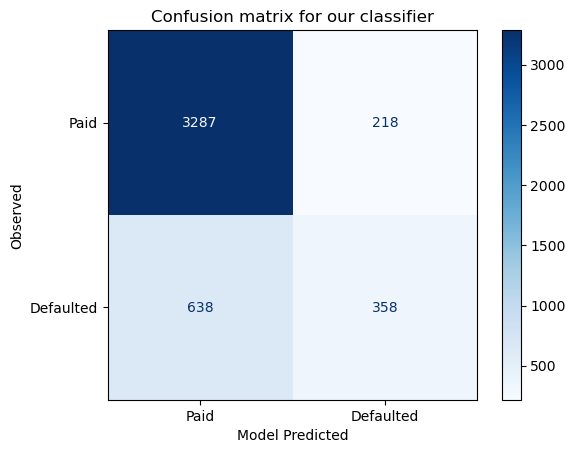

In [422]:
for model, name in models.items():
    print(name + ": Accuracy = {:.2f}%".format(model.score(scaled_X_valid, y_valid)*100)
               + ", Precision = {:.2f}%".format(precision_score(y_valid, model.predict(scaled_X_valid))*100)
               + ", Recall = {:.2f}%".format(recall_score(y_valid, model.predict(scaled_X_valid))*100)
               + ", Support = {:.0f}".format(np.sum(y_valid))
          )
    # Generate confusion matrix
    matrix = ConfusionMatrixDisplay.from_estimator(model, scaled_X_valid, y_valid, display_labels= ['Paid','Defaulted'], cmap='Blues')
    plt.title('Confusion matrix for our classifier')
    matrix.ax_.set(xlabel='Model Predicted', ylabel='Observed')
    plt.show(matrix)
    plt.show()

Our first implementation worked relatively well, but has flaws.

Both the **Logistic Regression** implementation and the **Neural Network implementation** reach an 80-81% overall accuracy.

- The **Logistic Regression** is rather precise with its predictions: 70% of model-predicted default predictions are in fact
observed defaults. However, it only picks up on 21% of the 996 observed defaults.
- The **Neural Network** is a little less precise with its predictions: 62% of model-predicted default predictions are
in fact observed defaults, but it picks up on substantially more observed defaults: 32% of the 996 observed defaults
are predicted by the model.

Despite the high precision and accuracy figures determined by each model, the low 'recall' figures (the proportion of
defaulting accounts detected by the model) mean that this model could only be used as a supportive tool to detect high-risk
accounts (at best), and cannot be relied upon to make automated decisions on behalf of risk management personnel.

## Now, to create, run, and assess these models yourself...


In [423]:
from torch import Tensor
train_dataset = TensorDataset(Tensor(np.array(scaled_X_train)), Tensor(np.array(y_train)).unsqueeze(dim=1))
valid_dataset = TensorDataset(Tensor(np.array(scaled_X_valid)), Tensor(np.array(y_valid)).unsqueeze(dim=1))

#### Allocate the size of the mini-batches to be loaded into the model once it begins computing.

In [424]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE)

# Defining and Running the model

## Task 4: Defining the LR Neural Network

The main selling point of PyTorch is the flexibility it allows in customising the model you want to compute.
You can create any type of Neural Network you like using the below class, by 'stacking' successive layers line by line,
with non-linearity functions in between. Your task below is to amend the layer details and forward propagation elements
in order to **produce a Logistic Regression model**.

*Hint:*
1. *Remember that each successive 'layer' in an Artificial Neural Network (a.k.a. Multilayer Perceptron) is made up of a
`linear` function, followed by an activation function. Linear layers in the `__init__` function require you to pass two arguments:
 i) the number of input parameters and ii) the number of parameters to be passed to the next layer.*
2. *You may find Lecture 4, Slide 9 helpful in conceptualising how you may define your model.*
3. *You may find the PyTorch documentation helpful in structuring your code for the task: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html.*

In [425]:
class LR(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
    # layer details
        super(LR, self).__init__()
        ##**YOUR CODE STARTS HERE**
        # a linear layer that outputs to 1 output which is then transformed using sigmoid activation function
        self.layers = nn.Sequential(
            torch.nn.Linear(n_inputs, 1),
            torch.nn.Sigmoid()
        )
        ##**YOUR CODE ENDS HERE**
    # forward propagation elements
    def forward(self, m):
        ##**YOUR CODE STARTS HERE**
        m = self.layers(m)
        ##**YOUR CODE ENDS HERE**
        return m

#### Inspecting the model, prior to it being run

In [426]:
LR_model = LR(X.shape[1]).to(device)
LR_model

LR(
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

## Task 5: Run, Train, and Validate the Efficacy of the Neural Network architecture.

There are 3 subtasks involved here, which require 1 line, 1 line, and 2 line solutions, respectively.

*Task 5.1 (1 line):* Initialise the Optimiser, which controls the gradient descent used to optimise parameter weights.
I suggest you implement an Adam optimiser, and pass through two arguments: i) the neural network's model parameters, and
ii) the learning rate.

*Task 5.2 (1 line) :* Construct the `for` loop, according to the number of epochs.

*Task 5.3 (2 lines):* Make predictions using your neural network and store them in `y_hat`. To do this, you must i) pass
`x_batch` as an argument in your neural network model, and ii) pass `y_hat` and `y_batch` as arguments in your loss function.

Apart from these tasks, the code implements the rest of the training process for you:
1. It trains the model and assesses the training set accuracy.
2. It backpropagates through the network using the `loss.backward()` line, and updates weights using the `optimizer.step()` line.
3. It tests the latest 'trained' weights at every epoch on the 1st set of holdout data (the validation set) to determine
 how well the model performs on unseen data.
4. It automatically implements the 'early stopping' regularisation technique seen in Lecture 4 by saving the model
parameters if the prevailing epoch's model results in a lower validation loss than the previously-saved set of parameters.

*Hint for Task 5.1: You may find the following documentation useful: https://pytorch.org/docs/stable/optim.html*

*Hint for Task 5.3: You may find the following documentation useful: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop*

In [427]:
"""
Runs a neural network on the basis of the input model architecture, and the parameters and hyperparameters that control the extent of learning within the model.

Parameters
---------
nn_model : class
    architecture of the neural network to be trained
loss_fun : function
    method of assessing the performance of the neural network on training / validation data
n_epochs : int
    number of times the gradients within the model are updated before the model is designated as 'trained' (each pass through the full set of data is called an epoch).
learning_rate : float
    size of the step taken when updating weights on the basis of the calculated gradients. Typically stated in negative powers of 10 (i.e. 10**-1 = 0.1, 10**-2 = 0.01, and so on).
print_every : int
    model iterations before printing a training progress update
Returns
-------
train_losses, valid_losses : array
    losses associated with running the model over n_epoch epochs.
"""

def run_model(nn_model, loss_fn, n_epochs, learning_rate, print_every):
    train_losses, valid_losses = [], []

    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    var_name = re.compile(r'\((.*)\).*$').search(code).groups()[0].split(",", 1)[0]

    ##**YOUR CODE STARTS HERE**
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)
    ##**YOUR ENDS STARTS HERE**

    ##**YOUR CODE STARTS HERE - one line**
    for epoch in range(n_epochs):
    ##**YOUR CODE ENDS HERE**
        running_loss_train = 0
        running_loss_valid = 0

        nn_model.train()

        for x_batch, y_batch in train_loader:

            optimizer.zero_grad()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            ##**YOUR CODE STARTS HERE - 2 lines**
            # Make predictions for this batch
            # y_hat is a series of probabilities
            y_hat = nn_model(x_batch)
            # Compute the loss
            loss = loss_fn(y_hat, y_batch)
            ##**YOUR CODE ENDS HERE**
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() * x_batch.size(0)

        epoch_loss_train = running_loss_train / len(train_loader.dataset)
        train_losses.append(epoch_loss_train)

        with torch.no_grad():

            nn_model.eval()

            for x_val, y_val in valid_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_hat = nn_model(x_val)
                loss = loss_fn(y_hat,y_val)
                running_loss_valid += loss.item() * x_val.size(0)

            epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

            if epoch > 0 and epoch_loss_valid < min(valid_losses):
                best_epoch = epoch
                torch.save(nn_model.state_dict(), f'./{var_name}_checkpoint.pth')

            valid_losses.append(epoch_loss_valid)
        if epoch % print_every == 0:
            print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
    print(f'Lowest loss recorded in epoch: {best_epoch}')
    return train_losses, valid_losses

#### Run and train the model

A couple notes at runtime:

- It is standard to:
    1. train the network for anywhere between 100 and 2000 epochs, depending on the progress of the loss function. All
    things held equal, the number of epochs is dependent on the learning rate
	2. using a learning rate of anywhere between 10^-1 to 10^-6.
	3. have 10 printed progress updates (i.e. if n_epoch = 200, PRINT_EVERY may be set to 20).

- If you get an `UnboundLocalError: local variable 'best_epoch' referenced before assignment` error code, that means the
neural network does not beat the baseline loss (step 0) in any of the following `n_epoch` learning steps. You may need to reconfigure your
(in order) i) learning rate, ii) network architecture, iii) variables included in the analysis.

- To know which loss function to implement, cross-check Lecture 4, Slide 13 with the following documentation: https://pytorch.org/docs/stable/nn.html#loss-functions

In [428]:
##**YOUR CODE STARTS HERE**
# BCELoss is used because the y_hat produced is probabilities which works well with BCELoss
loss_fn = torch.nn.BCELoss()
train_losses, valid_losses = run_model(LR_model, loss_fn, 200, 0.0001, 20)
##**YOUR CODE ENDS HERE**

<0> - Train. loss: 0.72 	 Valid. loss: 0.69
<20> - Train. loss: 0.48 	 Valid. loss: 0.48
<40> - Train. loss: 0.47 	 Valid. loss: 0.47
<60> - Train. loss: 0.46 	 Valid. loss: 0.47
<80> - Train. loss: 0.46 	 Valid. loss: 0.47
<100> - Train. loss: 0.46 	 Valid. loss: 0.47
<120> - Train. loss: 0.46 	 Valid. loss: 0.47
<140> - Train. loss: 0.46 	 Valid. loss: 0.47
<160> - Train. loss: 0.46 	 Valid. loss: 0.47
<180> - Train. loss: 0.46 	 Valid. loss: 0.47
Lowest loss recorded in epoch: 44


#### Plot the losses over epochs:

In [429]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title='Loss over epochs',
       xlabel='Epoch',
       ylabel='Loss')
ax.legend()
plt.show()

We train the model each epoch, and determine it's performance based on both the data upon which it was trained, and on a subset
of previously unseen data (the validation set). Based on the loss recorded each epoch, the weights adjust until a minimised
loss is found. At what point has a minimum been reached? Do you need to vary your learning parameters?

Remember that we are choosing our 'best fit' model on the basis of the weights and bias that generated the lowest validation loss.

#### Moving on to Neural Networks

## Task 6: Defining the MLP Neural Network

The purpose of this e-tivity is to carry out a like-for-comparison on the performance of a Logistic Regression model vs.
a Neural Network model, the latter of which can introduce additional complexity.

We have already defined our Logistic Regression model in Task 4, got it successfully running in Task 5, and assessed its
performance by visualing the loss functions over `n_epochs`.

Task 6 involves defining the architecture of *another* model: a Neural Network model. Your task below is to amend the layer
details and forward propagation elements in order to **produce an Artificial Neural Network** for the Binary Classification task.

**Requirements**:
- you should include no more than 3 linear layers (with associated activation functions)
- you may include any number of hidden units in the hidden `linear` layers, although I suggest you keep the number of hidden
units to powers of 2 (2, 4, 8, etc.) and go no higher than 64.
	- this does not apply to the input layer (the first of the two arguments passed <u>must</u> equal the number of input
variables in the model), and the output layer (the second of the two arguments passed <u>must</u> equal 1)
- you may include any type of non-linear activation function following each `linear` layer (although I suggest you stick
 with the 'common' ones provided in Lecture 4). Valid PyTorch activation functions can be found here:
 https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
- your final activation function should match the activation function used in Task 4.

*Hint:*
1. *Remember that each successive 'layer' in an Artificial Neural Network / Multilayer Perceptron is made up of a `linear`
 function, followed by an activation function. Linear layers in the `__init__` function require you to pass two arguments:
 i) the number of input parameters and ii) the number of parameters to be passed to the next layer.*
2. *You may find the PyTorch documentation helpful in structuring your code for the task: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html.*
3. *Reminder: Regardless of the activation functions you choose to implement between hidden linear layers, your final activation
 function must be appropriate for the Binary Classification problem we are addressing*

In [430]:
# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
    # layer details
        super(MLP, self).__init__()
        ##**YOUR CODE STARTS HERE**
        # 2 hidden layers with ReLU activation function with hidden units of 32 and 16
        # output is 1 single probability which is then transformed using sigmoid activation function
        self.layers = nn.Sequential(
            nn.Linear(n_inputs, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        ##**YOUR CODE ENDS HERE**
    # forward propagation elements
    def forward(self, m):
        ##**YOUR CODE STARTS HERE**
        m = self.layers(m)
        ##**YOUR CODE ENDS HERE**
        return m

#### Model is generated, and the loss function and optimisation method is chosen

In [431]:
MLP_model = MLP(X.shape[1]).to(device)
MLP_model

MLP(
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

#### Task 7: Run and train the Neural Network model

In [432]:
##**YOUR CODE STARTS HERE**
# same as following task 5 - just this time, we have a new model architecture to pass in.
# BCELoss is used because the y_hat produced is probabilities which works well with BCELoss
loss_fn = torch.nn.BCELoss()
train_losses, valid_losses = run_model(MLP_model, loss_fn, 200, 0.0001, 20)
##**YOUR CODE ENDS HERE**

<0> - Train. loss: 0.63 	 Valid. loss: 0.55
<20> - Train. loss: 0.44 	 Valid. loss: 0.44
<40> - Train. loss: 0.43 	 Valid. loss: 0.44
<60> - Train. loss: 0.43 	 Valid. loss: 0.44
<80> - Train. loss: 0.42 	 Valid. loss: 0.44
<100> - Train. loss: 0.42 	 Valid. loss: 0.44
<120> - Train. loss: 0.42 	 Valid. loss: 0.44
<140> - Train. loss: 0.42 	 Valid. loss: 0.44
<160> - Train. loss: 0.42 	 Valid. loss: 0.44
<180> - Train. loss: 0.41 	 Valid. loss: 0.44
Lowest loss recorded in epoch: 71


#### Plot the losses over epochs:

- reminder: look for both the drop and the rise (no matter how slight) in the validation loss curve.

In [433]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title='Loss over epochs',
       xlabel='Epoch',
       ylabel='Loss')
ax.legend()
plt.show()


#### Moving on to Model Performance Comparisons...

#### Load the best-performing Logistic Regression model (with the lowest validation loss):

In [434]:
LR_state_dict = torch.load('LR_model_checkpoint.pth')
LR_model.load_state_dict(LR_state_dict)

<All keys matched successfully>

#### Load the best-performing Multilayer Perceptron / Artificial Neural Network model (with the lowest validation loss):

In [435]:
MLP_state_dict = torch.load('MLP_model_checkpoint.pth')
MLP_model.load_state_dict(MLP_state_dict)

<All keys matched successfully>

#### Obtain the predictions from the best-performing Logistic Regression model on the validation set:

In [436]:
LR_y_pred, LR_y_valid= [], []

with torch.no_grad():

    LR_model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        LR_y_pred.append(LR_model(x_val))
        LR_y_valid.append(y_val)

LR_y_pred = torch.cat(LR_y_pred).numpy().flatten()
LR_y_valid = torch.cat(LR_y_valid).numpy().flatten()

#### Obtain the predictions from the best-performing Multilayer Perceptron model on the validation set:

In [437]:
MLP_y_pred, MLP_y_valid= [], []

with torch.no_grad():

    MLP_model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        MLP_y_pred.append(MLP_model(x_val))
        MLP_y_valid.append(y_val)

MLP_y_pred = torch.cat(MLP_y_pred).numpy().flatten()
MLP_y_valid = torch.cat(MLP_y_valid).numpy().flatten()


## Task 8: Classify Raw Probability Scores in to 0 and 1.

The models above produced probability scores ranging from 0 to 1. Your final task is to assign these scores to 0 or 1
to see how the models performed in the classification task, where a score will only be assigned to 1 if it has a probability
of above 50%, and 0 otherwise.

*Hint: you may find benefit from the numpy function `np.round`.*

**Additional Note:** When using this function, you can use a little mathematical trickery to embed a desire to be more conservative
or liberal in choosing accounts to isolate for further inspection.

The function will only predict a 'default' if the model predicts that a default is likely with >= 50%. However, maybe we
have adapted greater risk management controls in light of recent economic conditions, and we would like to isolate and
inspect moderately-risky accounts also - for example, those who have a 40%+ chance of defaulting, instead of 50%+. In that
case, we can add 10% on to all predictions - all those originally greater than 40% will be rounded to 1 (a 'Default'
prediction), while the remaining predictions will be rounded to 0 (a 'Paid' prediction).

We can also do the same process in the opposite direction if we want to relax our risk
management controls (for example, if we do not want to inspect accounts unless they have a >60% chance of defaulting).

In [453]:
##**YOUR CODE STARTS HERE**
threshold = 0.1
LR_y_valid_classifications = np.round(LR_y_valid)
# + threshold because we want to increase the probability of defaulting as the economy is assumed to be bad
LR_y_pred_classifications = np.round(np.add(LR_y_pred, threshold))

MLP_y_valid_classifications = np.round(MLP_y_valid)
# + threshold because we want to increase the probability of defaulting as the economy is assumed to be bad
MLP_y_pred_classifications = np.round(np.add(MLP_y_pred, threshold))
##**YOUR CODE ENDS HERE**

     Neural Network: Accuracy = 81.67%, Precision = 65.24%, Recall = 36.75%, Support = 996


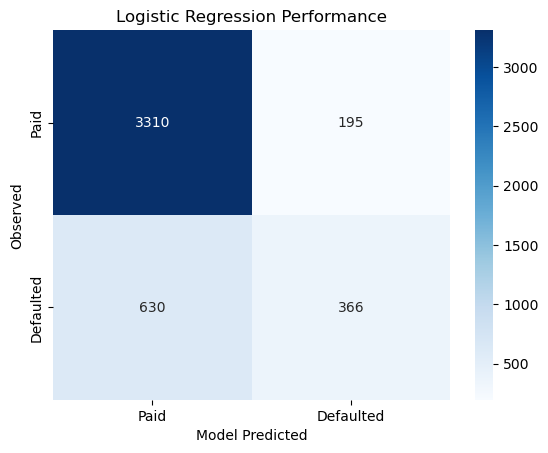

In [454]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(LR_y_valid_classifications,LR_y_pred_classifications), annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Model Predicted');ax.set_ylabel('Observed');
ax.xaxis.set_ticklabels(['Paid', 'Defaulted']); ax.yaxis.set_ticklabels(['Paid', 'Defaulted']);
ax.set_title('Logistic Regression Performance');
print(name + ": Accuracy = {:.2f}%".format(accuracy_score(LR_y_valid_classifications, LR_y_pred_classifications)*100)
           + ", Precision = {:.2f}%".format(precision_score(LR_y_valid_classifications, LR_y_pred_classifications)*100)
           + ", Recall = {:.2f}%".format(recall_score(LR_y_valid_classifications, LR_y_pred_classifications)*100)
           + ", Support = {:.0f}".format(np.sum(LR_y_valid_classifications))
      )

     Neural Network: Accuracy = 81.87%, Precision = 62.61%, Recall = 44.88%, Support = 996


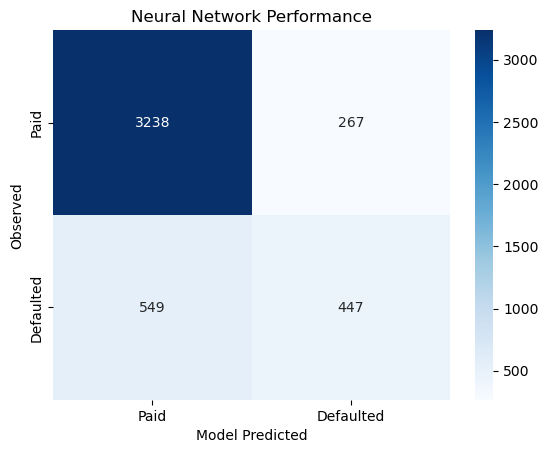

In [455]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(MLP_y_valid_classifications,MLP_y_pred_classifications), annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Model Predicted');ax.set_ylabel('Observed');
ax.xaxis.set_ticklabels(['Paid', 'Defaulted']); ax.yaxis.set_ticklabels(['Paid', 'Defaulted']);
ax.set_title('Neural Network Performance');
print(name + ": Accuracy = {:.2f}%".format(accuracy_score(MLP_y_valid_classifications, MLP_y_pred_classifications)*100)
           + ", Precision = {:.2f}%".format(precision_score(MLP_y_valid_classifications, MLP_y_pred_classifications)*100)
           + ", Recall = {:.2f}%".format(recall_score(MLP_y_valid_classifications, MLP_y_pred_classifications)*100)
           + ", Support = {:.0f}".format(np.sum(MLP_y_valid_classifications))
      )

## **Report your Results & Reflect on your choices here:**




















____

#### Final Note: Keep Network Depth/Size Restrained where Reasonable

A key point of emphasis that you should take from this notebook is that once you have a well-defined problem to explore,
backed by theoretical evidence and a targeted dataset (i.e. you are not sending through tonnes of raw data), you do not
need to rely on the complexity of very deep neural networks that take hours to run.

In fact, for numerical-based data, very deep neural networks (5+ layers) are discouraged in financial settings unless
kept very light or in some cases where the data is particularly abundant (i.e. tick data for stock prices). The reason
for this is that market behaviours and dynamics change all the time, introducing new nuances to the data structures, which
means that overfitting your data can lead to poor out-of-sample results.

Instead, focus effort on finding sensible possible solutions to your problems, and _then_ employ the non-linear complexities
afforded by Deep Learning that go beyond the capabilities of 'classic' statistical models like Linear/Logistic Regression.


--------------------------------------------------------------------Reflection--------------------------------------------------------------------

##### Logistic Regression (Task 4 & 5)
In the task, the optimizer I choose to use is the Adam otimizer with the parameters of the model to be adjusted. For the actual training, we use the model passed in to predict y_hat which is then used to calculated the loss with the loss function.

The loss function I chose to use is the BCELoss with learning rate of 0.0001. The model is trained for 200 epochs.
- Model: The model is created to do logistic regression which takes the input, pass through 1 linear layer to calculate a output which is a number between 0 and 1(as a result of a sigmoid activation function).
- Loss Function: nn.BCELoss is chosen because we are dealing with an classification problem which Cross Entropy Loss is a more suitable option instead of nn.MSELoss which is more suitable for regression problems. There is another cross entropy loss function which is nn.CrossEntropyLoss that is suitable for multi class classification. BCELoss is suitable for binary classification when the probablity is between 0 and 1.  
- Learning Rate: I used 0.0001 as it makes the training more gradual compared to 0.001 because we dont have lots of data with many features which ensures the speed of training is acceptable. On the other hand, a large LR might converge to suboptimal solution.
- Epochs: After a few rounds of training, I realized that 200 epochs is more than enough for the model to converge with the learning rate specified above.

##### MLP Network (Task 6 & 7) - Best Model
- Model: The model consist of 2 hidden layers of (32 & 16 hidden units). Each of the hidden layers transformed using Relu activation function to introduce non-linearity. The final output is then transformed to probability between 0 and 1 using sigmoid function. I tried to create a model with 3 hidden layers(64, 32, 16) and this model quick overfit the training data as the loss of training and validation data diverged to 0.2+(train) and 0.9+(validation).
- Loss Function: Same as above 
- Learning Rate: Same as above
- Epochs: Same as above